<a href="https://colab.research.google.com/github/valthoraval/stochastic/blob/master/Project_Market_Day_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - Market Day

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

![Stardew Valley](https://venturebeat.com/wp-content/uploads/2018/01/sw7rtba7p1xs77klsime.png)

It is Market Day! You've been working hard for a whole season, planting, watering, and taking care of crops. Now it is time to sell them in town. Just one problem though - your old truck can only carry so much weight. Which crops should you bring to maximize your profits? 

In this project, you will use a stochastic algorithm of your choice to find the best crop configuration you can load into your truck. You know how much stock you have of each crop, how much each crop weighs, and what price it will fetch at the market. You should use these values throughout the project.

Before we start, if you're using colab to run this notebook, you'll need to uncomment and run the following lines:

In [1]:
!wget https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/market.csv
!wget https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/recipes.csv
!pip install pymoo

--2022-12-06 22:28:11--  https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/market.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 927 [text/plain]
Saving to: ‘market.csv’

market.csv          100%[===================>]     927  --.-KB/s    in 0s      

2022-12-06 22:28:11 (40.8 MB/s) - ‘market.csv’ saved [927/927]

--2022-12-06 22:28:11--  https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/recipes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388 [text/plain]
Savin

In [2]:
import numpy as np
import pandas as pd
import pymoo
import copy

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

import random

In [3]:
df = pd.read_csv('market.csv', index_col=0)
df.head()

,stock,weight,price_A,price_B,price_C
Apple,5,5,1.00,0.5,1.1
Apricot,65,3,0.50,0.2,0.6
Blueberry,5,3,0.50,0.3,1.2
Cactus Fruit,90,4,0.75,0.3,0.3
Cherry,15,4,0.80,0.4,1.1


In [4]:
stock = df['stock'].to_dict()
weight = df['weight'].to_dict()
price = df['price_A'].to_dict()

In [5]:
stock

{'Apple': 5,
 'Apricot': 65,
 'Blueberry': 5,
 'Cactus Fruit': 90,
 'Cherry': 15,
 'Cranberry': 75,
 'Grape': 70,
 'Melon': 75,
 'Orange': 40,
 'Peach': 55,
 'Pomegranate': 5,
 'Rhubarb': 70,
 'Starfruit': 5,
 'Strawberry': 20,
 'Amaranth': 20,
 'Artichoke': 65,
 'Beet': 30,
 'Bok Choy': 55,
 'Cauliflower': 70,
 'Corn': 90,
 'Eggplant': 95,
 'Garlic': 95,
 'Green Bean': 55,
 'Hops': 75,
 'Hot Pepper': 25,
 'Kale': 5,
 'Parsnip': 10,
 'Potato': 55,
 'Pumpkin': 30,
 'Radish': 50,
 'Red Cabbage': 55,
 'Tomato': 65,
 'Wheat': 75,
 'Yam': 50,
 'Blackberry': 70}

To evaluate your possible load going to the market, we will use a function that takes in a dictionary of this type, specifying how many of each crop you will take. This function will take into the constraints of having enough stock of the crop type and of not surpassing the weight limit.

In [6]:
def evaluate(load, stock, weight, price, max_weight=5000):
    total_weight = 0
    total_price = 0
    for k in load:
        if load[k] <= stock[k]:
            total_price += load[k] * price[k]
            total_weight += load[k] * weight[k]
            if total_weight > max_weight:
                return 0
        else:
            return 0
    return total_price

In [7]:
def evaluate_autre(load, stock, weight, price, max_weight=5000):
    total_weight = 0
    total_price = 0
    for k in load:
        if load[k] <= stock[k]:
            total_price += load[k] * price[k]
            total_weight += load[k] * weight[k]
            if total_weight > max_weight:
                total_price -= load[k] * price[k]
                total_weight -= load[k] * weight[k]
                break
        else:
            pass
    print("Total weight", total_weight)
    return total_price

In [8]:
def toDict(lst):
    res_dct = {lst[i][0] : lst[i][1] for i in range(0, len(lst))}
    return res_dct

You can try this with an example load generated randomly:

In [9]:
trial_load = {}

for k in stock:
    trial_load[k] = np.random.randint(0, stock[k])

print(trial_load)
type(trial_load)
print(list(trial_load.items())[:10])
dict_1 = toDict(list(trial_load.items())[:10])
print(dict_1)
dict_2 = toDict(list(trial_load.items())[10:])
print(dict_2)
print({**dict_1, **dict_2})

{'Apple': 3, 'Apricot': 1, 'Blueberry': 2, 'Cactus Fruit': 17, 'Cherry': 10, 'Cranberry': 3, 'Grape': 14, 'Melon': 55, 'Orange': 2, 'Peach': 27, 'Pomegranate': 2, 'Rhubarb': 34, 'Starfruit': 3, 'Strawberry': 3, 'Amaranth': 10, 'Artichoke': 18, 'Beet': 12, 'Bok Choy': 9, 'Cauliflower': 55, 'Corn': 29, 'Eggplant': 81, 'Garlic': 15, 'Green Bean': 42, 'Hops': 69, 'Hot Pepper': 7, 'Kale': 1, 'Parsnip': 4, 'Potato': 34, 'Pumpkin': 21, 'Radish': 8, 'Red Cabbage': 47, 'Tomato': 52, 'Wheat': 58, 'Yam': 27, 'Blackberry': 6}
[('Apple', 3), ('Apricot', 1), ('Blueberry', 2), ('Cactus Fruit', 17), ('Cherry', 10), ('Cranberry', 3), ('Grape', 14), ('Melon', 55), ('Orange', 2), ('Peach', 27)]
{'Apple': 3, 'Apricot': 1, 'Blueberry': 2, 'Cactus Fruit': 17, 'Cherry': 10, 'Cranberry': 3, 'Grape': 14, 'Melon': 55, 'Orange': 2, 'Peach': 27}
{'Pomegranate': 2, 'Rhubarb': 34, 'Starfruit': 3, 'Strawberry': 3, 'Amaranth': 10, 'Artichoke': 18, 'Beet': 12, 'Bok Choy': 9, 'Cauliflower': 55, 'Corn': 29, 'Eggplant': 

In [10]:
print(list(trial_load.values())[5])
print(list(trial_load.keys())[5])
trial_2 = trial_load.copy()
print(trial_2)
trial_2.update({str(list(trial_load.keys())[5]):20})
print(trial_2)

3
Cranberry
{'Apple': 3, 'Apricot': 1, 'Blueberry': 2, 'Cactus Fruit': 17, 'Cherry': 10, 'Cranberry': 3, 'Grape': 14, 'Melon': 55, 'Orange': 2, 'Peach': 27, 'Pomegranate': 2, 'Rhubarb': 34, 'Starfruit': 3, 'Strawberry': 3, 'Amaranth': 10, 'Artichoke': 18, 'Beet': 12, 'Bok Choy': 9, 'Cauliflower': 55, 'Corn': 29, 'Eggplant': 81, 'Garlic': 15, 'Green Bean': 42, 'Hops': 69, 'Hot Pepper': 7, 'Kale': 1, 'Parsnip': 4, 'Potato': 34, 'Pumpkin': 21, 'Radish': 8, 'Red Cabbage': 47, 'Tomato': 52, 'Wheat': 58, 'Yam': 27, 'Blackberry': 6}
{'Apple': 3, 'Apricot': 1, 'Blueberry': 2, 'Cactus Fruit': 17, 'Cherry': 10, 'Cranberry': 20, 'Grape': 14, 'Melon': 55, 'Orange': 2, 'Peach': 27, 'Pomegranate': 2, 'Rhubarb': 34, 'Starfruit': 3, 'Strawberry': 3, 'Amaranth': 10, 'Artichoke': 18, 'Beet': 12, 'Bok Choy': 9, 'Cauliflower': 55, 'Corn': 29, 'Eggplant': 81, 'Garlic': 15, 'Green Bean': 42, 'Hops': 69, 'Hot Pepper': 7, 'Kale': 1, 'Parsnip': 4, 'Potato': 34, 'Pumpkin': 21, 'Radish': 8, 'Red Cabbage': 47, 'T

In [ ]:
evaluate(trial_load, stock, weight, price)

686.5999999999999

## Challenge 1

Use a stochastic algorithm to find the configuration of crops that maximizes profit while respecting the constraints of the weight limit and stock. You can use any of the class code or a library like `pymoo`. You should create a reasonable representation for the problem and appropriate modification functions like mutation and crossover. You can also modify the evaluation function, as long as your final solution is valid according to the weight and stock constraints.

Include your code for optimization, any visualizations of the optimization process, as well as code to show the final market load and profit gained. Can you beat the random trial load profits?

Hint: this is a constrained case of the [knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem)

In [11]:
n_population = 100
population_trail_load = []

for i in range(n_population):
    trial_load = {}
    for k in stock:
        trial_load[k] = np.random.randint(0, stock[k])
    population_trail_load.append(trial_load)
#trial_load
len(population_trail_load)
print(population_trail_load[20])
print(type(population_trail_load[20]))

print(len(population_trail_load))

{'Apple': 4, 'Apricot': 50, 'Blueberry': 0, 'Cactus Fruit': 34, 'Cherry': 5, 'Cranberry': 43, 'Grape': 4, 'Melon': 61, 'Orange': 8, 'Peach': 27, 'Pomegranate': 4, 'Rhubarb': 69, 'Starfruit': 3, 'Strawberry': 15, 'Amaranth': 0, 'Artichoke': 28, 'Beet': 14, 'Bok Choy': 16, 'Cauliflower': 24, 'Corn': 71, 'Eggplant': 63, 'Garlic': 5, 'Green Bean': 23, 'Hops': 55, 'Hot Pepper': 4, 'Kale': 1, 'Parsnip': 1, 'Potato': 39, 'Pumpkin': 4, 'Radish': 37, 'Red Cabbage': 52, 'Tomato': 19, 'Wheat': 66, 'Yam': 3, 'Blackberry': 6}
<class 'dict'>
100


In [12]:
def evaluate_population(population):
    fit = []
    for i in range(len(population)):
        prix = evaluate(population[i], stock, weight, price)
        fit.append(prix)
    return fit

In [13]:
fitness = evaluate_population(population_trail_load)
print(fitness)

[790.0, 807.2500000000001, 963.0500000000002, 800.95, 655.7, 698.9000000000001, 774.6500000000002, 761.0500000000001, 681.4, 658.45, 703.7500000000001, 685.9, 638.1999999999999, 603.2000000000003, 587.3, 684.3, 750.75, 699.75, 0, 0, 720.7500000000001, 598.0999999999999, 714.2, 684.9999999999999, 774.8, 506.9500000000001, 650.55, 721.65, 850.8, 538.7, 891.7499999999999, 641.5, 0, 708.4999999999999, 621.5, 643.9, 611.25, 493.15000000000003, 743.65, 745.7500000000001, 744.8500000000001, 820.45, 0, 787.6499999999999, 0, 768.0, 754.4999999999999, 687.9499999999999, 822.3500000000001, 776.3499999999999, 588.45, 819.0, 799.3499999999999, 579.6, 649.85, 643.85, 830.6999999999999, 759.1500000000001, 791.2499999999999, 774.8, 694.7, 655.6, 846.65, 716.0000000000001, 636.4, 732.6499999999999, 664.8500000000003, 796.15, 637.7999999999998, 810.9499999999999, 794.2499999999999, 768.55, 605.0, 701.7, 740.95, 780.3999999999999, 768.2500000000001, 633.65, 790.9500000000002, 646.6, 763.5, 771.55, 752.10

In [14]:
def fp_selection(population, fitness):
    m = max(fitness)
    p = np.zeros(len(fitness))
    for i in range(len(fitness)):
        p[i] = (m - fitness[i])
    p /= sum(p)
    rng = np.random.default_rng()
    n = len(population)
    #continueSelection = True
    '''
    while(continueSelection):
        ind = rng.choice(n, p=p)
        #print(ind)
        if(fitness[ind] != 0):
           continueSelection = False
    '''
    ind = rng.choice(n, p=p)
    return population[ind], fitness[ind]

20


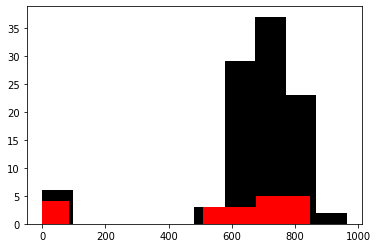

In [15]:
fp_fits = np.zeros(20)
for i in range(20):
    p, f = fp_selection(population_trail_load, fitness)
    fp_fits[i] = f
plt.hist(fitness, color='k')
#plt.hist(efit, color='b')
plt.hist(fp_fits, color='r');
print(fp_fits.size)

In [16]:
def truncation_selection(population, fitness, p=0.2):
    n_elites = len(population) - int(np.floor(len(population) * p))
    #print(n_elites)
    elites = np.argsort(np.array(fitness))[n_elites:]
    selected_pop, selected_fitness = [], []
    for index in elites:
        selected_pop.append(population[index])
        selected_fitness.append(fitness[index])
    return selected_pop, selected_fitness

elites [{'Apple': 3, 'Apricot': 18, 'Blueberry': 1, 'Cactus Fruit': 73, 'Cherry': 2, 'Cranberry': 52, 'Grape': 13, 'Melon': 35, 'Orange': 0, 'Peach': 51, 'Pomegranate': 4, 'Rhubarb': 56, 'Starfruit': 2, 'Strawberry': 11, 'Amaranth': 7, 'Artichoke': 31, 'Beet': 14, 'Bok Choy': 6, 'Cauliflower': 60, 'Corn': 86, 'Eggplant': 28, 'Garlic': 7, 'Green Bean': 14, 'Hops': 30, 'Hot Pepper': 22, 'Kale': 0, 'Parsnip': 9, 'Potato': 28, 'Pumpkin': 22, 'Radish': 14, 'Red Cabbage': 35, 'Tomato': 18, 'Wheat': 10, 'Yam': 38, 'Blackberry': 18}, {'Apple': 3, 'Apricot': 20, 'Blueberry': 2, 'Cactus Fruit': 58, 'Cherry': 6, 'Cranberry': 15, 'Grape': 69, 'Melon': 55, 'Orange': 29, 'Peach': 48, 'Pomegranate': 1, 'Rhubarb': 66, 'Starfruit': 3, 'Strawberry': 2, 'Amaranth': 3, 'Artichoke': 25, 'Beet': 14, 'Bok Choy': 28, 'Cauliflower': 59, 'Corn': 22, 'Eggplant': 25, 'Garlic': 90, 'Green Bean': 23, 'Hops': 28, 'Hot Pepper': 11, 'Kale': 1, 'Parsnip': 0, 'Potato': 17, 'Pumpkin': 14, 'Radish': 16, 'Red Cabbage': 0, 

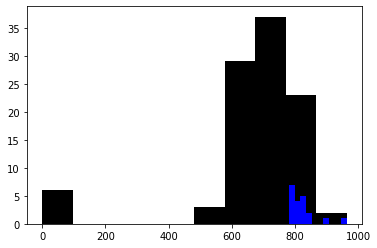

In [17]:
p_elites, efit = truncation_selection(population_trail_load, fitness)
plt.hist(fitness, color='k')
plt.hist(efit, color='b');
print('elites',p_elites,len(p_elites))
print(len(p_elites), len(efit), len(population_trail_load), len(fitness))

In [18]:
def tournament_selection(population, fitness, t_size=3):
    rng = np.random.default_rng()
    tournament = rng.choice(len(population), size=t_size)
    #print('tournament',type(tournament))
    #print('tournament', tournament)
    ind = []
    for i in range(len(tournament)):
        ind.append(fitness[tournament[i]])
    ind = ind.index(max(ind))
    return population[ind], fitness[ind]


In [19]:
for j in range(5):
    p, f = tournament_selection(population_trail_load, fitness, t_size=3)
    print(p)
    print(f)

{'Apple': 3, 'Apricot': 45, 'Blueberry': 2, 'Cactus Fruit': 88, 'Cherry': 9, 'Cranberry': 34, 'Grape': 25, 'Melon': 7, 'Orange': 23, 'Peach': 12, 'Pomegranate': 4, 'Rhubarb': 10, 'Starfruit': 3, 'Strawberry': 1, 'Amaranth': 17, 'Artichoke': 45, 'Beet': 29, 'Bok Choy': 26, 'Cauliflower': 52, 'Corn': 46, 'Eggplant': 68, 'Garlic': 86, 'Green Bean': 2, 'Hops': 58, 'Hot Pepper': 16, 'Kale': 4, 'Parsnip': 8, 'Potato': 14, 'Pumpkin': 0, 'Radish': 33, 'Red Cabbage': 35, 'Tomato': 38, 'Wheat': 42, 'Yam': 32, 'Blackberry': 66}
790.0
{'Apple': 4, 'Apricot': 62, 'Blueberry': 3, 'Cactus Fruit': 30, 'Cherry': 13, 'Cranberry': 35, 'Grape': 69, 'Melon': 38, 'Orange': 31, 'Peach': 33, 'Pomegranate': 0, 'Rhubarb': 23, 'Starfruit': 0, 'Strawberry': 15, 'Amaranth': 6, 'Artichoke': 52, 'Beet': 29, 'Bok Choy': 52, 'Cauliflower': 64, 'Corn': 86, 'Eggplant': 62, 'Garlic': 67, 'Green Bean': 30, 'Hops': 46, 'Hot Pepper': 5, 'Kale': 1, 'Parsnip': 0, 'Potato': 40, 'Pumpkin': 16, 'Radish': 49, 'Red Cabbage': 15, '

In [20]:
def crossover(parent1, parent2):
    rng = np.random.default_rng()
    x = rng.choice(np.arange(1, np.minimum(len(parent1)-1, len(parent2)-1)))
    #print(x)
    p1 = toDict(list(parent1.items())[:x])
    p2 = toDict(list(parent2.items())[x:])
    child = {**p1, **p2}
    return child

In [21]:
parent1, _ = tournament_selection(population_trail_load, fitness, t_size=3)
parent2, _ = tournament_selection(population_trail_load, fitness, t_size=3)
 
print(parent1)
print(parent2)
print('Child')
print(crossover(parent1, parent2))

{'Apple': 3, 'Apricot': 45, 'Blueberry': 2, 'Cactus Fruit': 88, 'Cherry': 9, 'Cranberry': 34, 'Grape': 25, 'Melon': 7, 'Orange': 23, 'Peach': 12, 'Pomegranate': 4, 'Rhubarb': 10, 'Starfruit': 3, 'Strawberry': 1, 'Amaranth': 17, 'Artichoke': 45, 'Beet': 29, 'Bok Choy': 26, 'Cauliflower': 52, 'Corn': 46, 'Eggplant': 68, 'Garlic': 86, 'Green Bean': 2, 'Hops': 58, 'Hot Pepper': 16, 'Kale': 4, 'Parsnip': 8, 'Potato': 14, 'Pumpkin': 0, 'Radish': 33, 'Red Cabbage': 35, 'Tomato': 38, 'Wheat': 42, 'Yam': 32, 'Blackberry': 66}
{'Apple': 4, 'Apricot': 62, 'Blueberry': 3, 'Cactus Fruit': 30, 'Cherry': 13, 'Cranberry': 35, 'Grape': 69, 'Melon': 38, 'Orange': 31, 'Peach': 33, 'Pomegranate': 0, 'Rhubarb': 23, 'Starfruit': 0, 'Strawberry': 15, 'Amaranth': 6, 'Artichoke': 52, 'Beet': 29, 'Bok Choy': 52, 'Cauliflower': 64, 'Corn': 86, 'Eggplant': 62, 'Garlic': 67, 'Green Bean': 30, 'Hops': 46, 'Hot Pepper': 5, 'Kale': 1, 'Parsnip': 0, 'Potato': 40, 'Pumpkin': 16, 'Radish': 49, 'Red Cabbage': 15, 'Tomato

In [22]:
def crossover_2(parent1, parent2):
    rng = np.random.default_rng()
    x = rng.choice(np.arange(1, np.minimum(len(parent1)-1, len(parent2)-1)))
    #print(x)
    cross_list = list(np.zeros(len(parent1)))
    ind_list = random.sample(list(np.arange(len(parent1))),x)
    for index in ind_list:
        cross_list[index] = 1
    #print(cross_list)
    child = {}
    for i in range(len(parent1)):
        if cross_list[i] == 0:
            child[list(parent1.keys())[i]] = list(parent1.values())[i]
        else:
            child[list(parent2.keys())[i]] = list(parent2.values())[i]
    return child

In [23]:
parent1, _ = tournament_selection(population_trail_load, fitness, t_size=3)
parent2, _ = tournament_selection(population_trail_load, fitness, t_size=3)
 
print(parent1)
print(parent2)
print('Child')
print(crossover_2(parent1, parent2))

{'Apple': 4, 'Apricot': 62, 'Blueberry': 3, 'Cactus Fruit': 30, 'Cherry': 13, 'Cranberry': 35, 'Grape': 69, 'Melon': 38, 'Orange': 31, 'Peach': 33, 'Pomegranate': 0, 'Rhubarb': 23, 'Starfruit': 0, 'Strawberry': 15, 'Amaranth': 6, 'Artichoke': 52, 'Beet': 29, 'Bok Choy': 52, 'Cauliflower': 64, 'Corn': 86, 'Eggplant': 62, 'Garlic': 67, 'Green Bean': 30, 'Hops': 46, 'Hot Pepper': 5, 'Kale': 1, 'Parsnip': 0, 'Potato': 40, 'Pumpkin': 16, 'Radish': 49, 'Red Cabbage': 15, 'Tomato': 40, 'Wheat': 8, 'Yam': 41, 'Blackberry': 33}
{'Apple': 4, 'Apricot': 62, 'Blueberry': 3, 'Cactus Fruit': 30, 'Cherry': 13, 'Cranberry': 35, 'Grape': 69, 'Melon': 38, 'Orange': 31, 'Peach': 33, 'Pomegranate': 0, 'Rhubarb': 23, 'Starfruit': 0, 'Strawberry': 15, 'Amaranth': 6, 'Artichoke': 52, 'Beet': 29, 'Bok Choy': 52, 'Cauliflower': 64, 'Corn': 86, 'Eggplant': 62, 'Garlic': 67, 'Green Bean': 30, 'Hops': 46, 'Hot Pepper': 5, 'Kale': 1, 'Parsnip': 0, 'Potato': 40, 'Pumpkin': 16, 'Radish': 49, 'Red Cabbage': 15, 'Toma

In [37]:

def mutate(ind):
    rng = np.random.default_rng()
    continue_mutation = True
    while(continue_mutation):
        x = rng.choice(len(ind)-1)
        #print('x_mutate',x)
        if((list(ind.values())[x] < list(stock.values())[x+1]) and
           (list(ind.values())[x+1] < list(stock.values())[x])):
              child = ind.copy()
              child.update({str(list(ind.keys())[x]):list(ind.values())[x+1]})
              child.update({str(list(ind.keys())[x+1]):list(ind.values())[x]})
              continue_mutation = False
    return child


In [38]:
def mutate_2(ind):
    rng = np.random.default_rng()
    continue_mutation = True
    while(continue_mutation):
        x = rng.choice(len(ind)-1)
        #print('x_mutate',x)
        if((list(ind.values())[x]+1 < list(stock.values())[x]) and
           (list(ind.values())[x+1]-1 > 0)):
              child = ind.copy()
              child.update({str(list(ind.keys())[x]):list(ind.values())[x]+1})
              child.update({str(list(ind.keys())[x+1]):list(ind.values())[x+1]-1})
              continue_mutation = False
    return child

In [25]:
parent1, _ = tournament_selection(population_trail_load, fitness, t_size=3)
parent2, _ = tournament_selection(population_trail_load, fitness, t_size=3)
print(parent1)
print(parent2)
child_1 = crossover(parent1, parent2)
child_1 = mutate(child_1)
print(child_1)

{'Apple': 4, 'Apricot': 62, 'Blueberry': 3, 'Cactus Fruit': 30, 'Cherry': 13, 'Cranberry': 35, 'Grape': 69, 'Melon': 38, 'Orange': 31, 'Peach': 33, 'Pomegranate': 0, 'Rhubarb': 23, 'Starfruit': 0, 'Strawberry': 15, 'Amaranth': 6, 'Artichoke': 52, 'Beet': 29, 'Bok Choy': 52, 'Cauliflower': 64, 'Corn': 86, 'Eggplant': 62, 'Garlic': 67, 'Green Bean': 30, 'Hops': 46, 'Hot Pepper': 5, 'Kale': 1, 'Parsnip': 0, 'Potato': 40, 'Pumpkin': 16, 'Radish': 49, 'Red Cabbage': 15, 'Tomato': 40, 'Wheat': 8, 'Yam': 41, 'Blackberry': 33}
{'Apple': 4, 'Apricot': 62, 'Blueberry': 3, 'Cactus Fruit': 30, 'Cherry': 13, 'Cranberry': 35, 'Grape': 69, 'Melon': 38, 'Orange': 31, 'Peach': 33, 'Pomegranate': 0, 'Rhubarb': 23, 'Starfruit': 0, 'Strawberry': 15, 'Amaranth': 6, 'Artichoke': 52, 'Beet': 29, 'Bok Choy': 52, 'Cauliflower': 64, 'Corn': 86, 'Eggplant': 62, 'Garlic': 67, 'Green Bean': 30, 'Hops': 46, 'Hot Pepper': 5, 'Kale': 1, 'Parsnip': 0, 'Potato': 40, 'Pumpkin': 16, 'Radish': 49, 'Red Cabbage': 15, 'Toma

In [66]:
def ga_step(population):
    fitness = evaluate_population(population)
    fp_fits = np.zeros(20)
    next_pop, _ = truncation_selection(population, fitness)
    '''
    next_pop = []
    for i in range(20):
        p, f = fp_selection(population_trail_load, fitness)
        next_pop.append(p)
        fp_fits[i] = f
    '''
    while len(next_pop) < len(population):
        parent1, _ = tournament_selection(population, fitness)
        parent2, _ = tournament_selection(population, fitness)
        #child = crossover(parent1, parent2)
        child = crossover_2(parent1, parent2)
        child = mutate_2(child)
        next_pop.append(child)
    #next_fitness = evaluate_population(next_pop)
    return next_pop, fitness

In [67]:
n_population = 100
population_trail_load = []

for i in range(n_population):
    trial_load = {}
    for k in stock:
        trial_load[k] = np.random.randint(0, stock[k])
    population_trail_load.append(trial_load)

fitness = evaluate_population(population_trail_load)

In [91]:
maxfit = []
n_gen = 2000
maxfit = np.zeros(n_gen)
pop = population_trail_load
for i in range(n_gen):
    pop, fitn = ga_step(pop)
    maxfit[i] = np.max(fitn)
    if (i > 2) and (maxfit[i] > maxfit[i-1]):
        print(i, maxfit[i])

4 881.4000000000001
7 882.65
8 935.0999999999998
13 942.4999999999999
15 943.5000000000002
17 947.9
18 962.35
21 982.2499999999999
26 985.5999999999998
28 1006.9999999999999
31 1008.3499999999999
36 1018.1499999999999
43 1024.9999999999998
47 1025.75
48 1036.3
62 1040.8
63 1042.85
69 1044.75
85 1046.3999999999999
93 1047.3999999999999
106 1047.6
109 1047.7499999999998
110 1048.8999999999999
113 1050.9
121 1051.4
122 1052.7
131 1053.4500000000003
133 1053.5499999999997
136 1053.6000000000001
137 1053.75
138 1054.45
141 1054.8000000000002
143 1056.3
145 1056.8
147 1057.45
151 1058.0
156 1058.5500000000002
158 1059.5000000000002
159 1059.6
165 1060.65
168 1060.7
172 1061.0500000000004
173 1061.55
175 1062.6000000000001
180 1063.8000000000002
189 1065.25
191 1065.3500000000001
195 1065.7000000000003
197 1066.95
201 1067.35
202 1067.55
207 1067.7500000000002
209 1068.5000000000002
211 1068.8500000000001
214 1068.95
216 1068.9500000000003
218 1069.1500000000003
219 1070.65
228 1072.300000000

## Challenge 2


The agricultural market in this world is highly variable. This time, you'll be selling your load to a reseller, but you're not sure which one. Each reseller has different prices, so it depends on which one you'll meet. To be prepared, you should explore the possible options.

In [32]:
price_a = df['price_A'].to_dict()
price_b = df['price_B'].to_dict()
price_c = df['price_C'].to_dict()

In [33]:
price_a['Cherry'], price_b['Cherry'], price_c['Cherry']

(0.8, 0.4, 1.1)

Given that cherries have very different prices between the different resellers, the example load we made ealier would fetch a wildly different price depending on the reseller:

In [34]:
a = evaluate(trial_load, stock, weight, price_a)
b = evaluate(trial_load, stock, weight, price_b)
c = evaluate(trial_load, stock, weight, price_c)
print(a, b, c)

679.9 319.70000000000005 413.6000000000001


Prepare four different options for your market day haul: one option that will be good for reseller A, one for reseller B, one for reseller C, and one which would be pretty good for all three. Display these options and compare their different prices.

In [113]:
def evaluate_population_2(population, price_2):
    fit = []
    for i in range(len(population)):
      if(price_2 != 'all_three'):
        prix_2 = evaluate(population[i], stock, weight, price_2)
        fit.append(prix_2)
      else:
        prix_2 = evaluate(population[i], stock, weight, price_a) + evaluate(population[i], stock, weight, price_b) + evaluate(population[i], stock, weight, price_c)
        prix_2 = prix_2/3
        fit.append(prix_2)
    return fit

In [114]:
def ga_step_2(population, prix):
    fitness = evaluate_population_2(population, prix)
    fp_fits = np.zeros(20)
    next_pop, _ = truncation_selection(population, fitness)
    while len(next_pop) < len(population):
        parent1, _ = tournament_selection(population, fitness)
        parent2, _ = tournament_selection(population, fitness)
        #child = crossover(parent1, parent2)
        child = crossover_2(parent1, parent2)
        child = mutate_2(child)
        next_pop.append(child)
    #next_fitness = evaluate_population(next_pop)
    return next_pop, fitness

In [115]:
n_population = 100
population_trail_load = []

for i in range(n_population):
    trial_load = {}
    for k in stock:
        trial_load[k] = np.random.randint(0, stock[k])
    population_trail_load.append(trial_load)

fitness = evaluate_population(population_trail_load)

In [130]:
from pyparsing.helpers import nullDebugAction
maxfit = []
list_price = [price_a, price_b, price_c, 'all_three']
#list_price = ['all_three']
list_etiquette = ['price_a', 'price_b', 'price_c', 'all_three']
#list_etiquette = ['all_three']

for p in list_price:
    result = (0,0)
    n_gen = 1000
    maxfit = np.zeros(n_gen)
    pop = population_trail_load
    best_pop = {}
    for i in range(n_gen):
        pop, fitn = ga_step_2(pop, p)
        maxfit[i] = np.max(fitn)
        if (i > 2) and (maxfit[i] > maxfit[i-1]):
            #print(list_etiquette[list_price.index(p)], i, maxfit[i])
            result = (i, maxfit[i])
            #print(np.where(fitn == np.max(fitn))[0])
            ind = int(np.where(fitn == np.max(fitn))[0][0])
            #print('ind',ind)
            best_pop = pop[ind]
    if p != 'all_three':
        print(list_etiquette[list_price.index(p)], result[0], result[1])
        print(best_pop)
    else:
        a = evaluate(best_pop, stock, weight, price_a)
        b = evaluate(best_pop, stock, weight, price_b)
        c = evaluate(best_pop, stock, weight, price_c)
        print(list_etiquette[list_price.index(p)], result[0], (a, b, c))
        print(best_pop)
        

price_a 576 1096.25
{'Apple': 4, 'Apricot': 14, 'Blueberry': 1, 'Cactus Fruit': 56, 'Cherry': 14, 'Cranberry': 26, 'Grape': 69, 'Melon': 12, 'Orange': 27, 'Peach': 53, 'Pomegranate': 3, 'Rhubarb': 1, 'Starfruit': 0, 'Strawberry': 19, 'Amaranth': 19, 'Artichoke': 64, 'Beet': 29, 'Bok Choy': 54, 'Cauliflower': 69, 'Corn': 89, 'Eggplant': 94, 'Garlic': 94, 'Green Bean': 33, 'Hops': 1, 'Hot Pepper': 18, 'Kale': 4, 'Parsnip': 9, 'Potato': 54, 'Pumpkin': 2, 'Radish': 49, 'Red Cabbage': 46, 'Tomato': 64, 'Wheat': 35, 'Yam': 49, 'Blackberry': 53}
price_b 757 442.1
{'Apple': 4, 'Apricot': 48, 'Blueberry': 4, 'Cactus Fruit': 59, 'Cherry': 14, 'Cranberry': 60, 'Grape': 27, 'Melon': 51, 'Orange': 39, 'Peach': 40, 'Pomegranate': 4, 'Rhubarb': 60, 'Starfruit': 1, 'Strawberry': 19, 'Amaranth': 19, 'Artichoke': 1, 'Beet': 23, 'Bok Choy': 1, 'Cauliflower': 15, 'Corn': 23, 'Eggplant': 2, 'Garlic': 1, 'Green Bean': 1, 'Hops': 69, 'Hot Pepper': 21, 'Kale': 4, 'Parsnip': 9, 'Potato': 4, 'Pumpkin': 20, 'Rad

Hint: you can use a multi-objective algorithm to optimize for all three reseller prices at the same time.

In [ ]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary

class MOPMD(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        
        # lower bound
        variable = {}
        
        for k in stock:
            trial_load[k] = Integer(0, stock[k])
        
        self.n_obj
        
        super().__init__(n_var=trial_load, n_obj=3, **kwargs)
        
    def evaluate(self, load, stock, weight, price, max_weight=5000):
        total_weight = 0
        total_price = 0
        for k in load:
            if load[k] <= stock[k]:
                total_price += load[k] * price[k]
                total_weight += load[k] * weight[k]
                if total_weight > max_weight:
                    total_price = 0
                    break
            else:
                total_price = 0
                break
        return total_price
    
    def evaluate_population_2(self, population, out, price_2):
        fit = np.zeros((len(self.n_obs),len(self.population)))
        for p in range(len(self.n_obs)):
            for i in range(len(self.population)):
                prix_2 = self.evaluate(population[i], stock, weight, price_2)
                fit[p][i] = prix_2
        out["F"] = [fit[0][:], fit[1][:], fit[2][:]]

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.erx import EdgeRecombinationCrossover
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.mutation.inversion import InversionMutation

algorithm = NSGA2(
    pop_size=100,
    sampling=PermutationRandomSampling(),
    crossover=EdgeRecombinationCrossover(),
    mutation=InversionMutation(),
    eliminate_duplicates=True
)

## Challenge 3

You decide to preprare some of your crops by making food for the market day. You know a number of recipes and are famous for your delicious fruit pies.

In [ ]:
recipes = {'Ratatouille': {'Eggplant': 2, 'Garlic': 2, 'Tomato': 4, 'Hot Pepper': 1},
 'Apple Pie': {'Apple': 10, 'Wheat': 5},
 'Apricot Pie': {'Apricot': 10, 'Wheat': 5},
 'Cherry Pie': {'Cherry': 10, 'Wheat': 5},
 'Rhubarb Pie': {'Rhubarb': 10, 'Wheat': 5},
 'Strawberry Pie': {'Strawberry': 10, 'Wheat': 5},
 'Blackberry Pie': {'Blackberry': 10, 'Wheat': 5},
 'Pumpkin Pie': {'Pumpkin': 10, 'Wheat': 5},
 'Pizza': {'Tomato': 3, 'Wheat': 2, 'Artichoke': 1},
 'Baba Ghanoush': {'Eggplant': 2, 'Garlic': 4},
 'Squash Soup': {'Yam': 3, 'Pumpkin': 1},
 'Peach Beer': {'Hops': 3, 'Peach': 1},
 'Blackberry Beer': {'Hops': 3, 'Blackberry': 1}}

These recipes sell for good prices at each of the resellers:

In [ ]:
df = pd.read_csv('recipes.csv', index_col=0)
df.head()

,price_A,price_B,price_C
Ratatouille,68.0,13.0,52.0
Apple Pie,146.0,84.0,176.0
Apricot Pie,81.0,46.0,110.0
Cherry Pie,120.0,72.0,176.0
Rhubarb Pie,133.0,162.0,98.0


In [ ]:
price_a.update(df['price_A'].to_dict())
price_b.update(df['price_B'].to_dict())
price_c.update(df['price_C'].to_dict())
price_a['Apple Pie'], price_b['Apple Pie'], price_c['Apple Pie']

(146.0, 84.0, 176.0)

Modify the evaluation function to take into account these recipes, making sure not to break the weight or stock constraints. The weight of a recipe is the sum total weight of the ingredients, and you can not make a recipe if you don't have the remaining stock of ingredients. Here's an example of calculating the total weight of a random load of only recipes:

In [ ]:
recipe_load = {}
for k in recipes:
    recipe_load[k] = np.random.randint(0, 5)
recipe_load

{'Ratatouille': 2,
 'Apple Pie': 0,
 'Apricot Pie': 2,
 'Cherry Pie': 3,
 'Rhubarb Pie': 2,
 'Strawberry Pie': 0,
 'Blackberry Pie': 2,
 'Pumpkin Pie': 1,
 'Pizza': 2,
 'Baba Ghanoush': 0,
 'Squash Soup': 0,
 'Peach Beer': 4,
 'Blackberry Beer': 3}

In [ ]:
def get_weight(recipe_load, recipes, weight):
    total_weight = 0
    for k in recipe_load:
        ingredients = recipes[k]
        w = 0
        for i in ingredients:
            w += weight[i] * ingredients[i]
        total_weight += w * recipe_load[k]
    return total_weight

In [ ]:
get_weight(recipe_load, recipes, weight)

700

Once you've modified the evaluation function, rerun the optimization algorithm to find a new load for the three resellers, and one load which is good for all three. Display this result and the profit gained, making sure that the constraints are met.

## Evaluation

You should submit a saved copy of your notebook (including all of the cell output) to the LMS by December 13th, EOD. You may work with one partner, but you must **individually submit a notebook**. You will be graded based on your results, your code, and any text or visual explanations, according to the following rubric:

Criterion | Points
--- | ---
Results - Challenge 1 | 7
Results - Challenge 2 | 5
Results - Challenge 3 | 3
Presentation (code, text) | 5